In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import mlflow
import mlflow.sklearn

import joblib

In [60]:
mlflow.set_tracking_uri("file:./mlruns") 

In [61]:
# Charger les données
data = pd.read_csv("data/housing.csv")

# Afficher un aperçu des données
print(data.head())

# Vérifier les valeurs manquantes
print(data.isnull().sum())

# Résumé statistique des données
print(data.describe())


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  
longitude               0
latitude                0
housing_median_age     

In [62]:
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [63]:
# Supprimer les lignes contenant des valeurs manquantes
data.dropna(subset=['total_bedrooms'], inplace=True)


In [64]:
# Encodage one-hot
data = pd.get_dummies(data, columns=['ocean_proximity'], drop_first=True)


In [65]:
# Standardiser les colonnes numériques
numerical_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
scaler = StandardScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])


In [66]:
# Diviser les données
X = data.drop("median_house_value", axis=1)
y = data["median_house_value"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


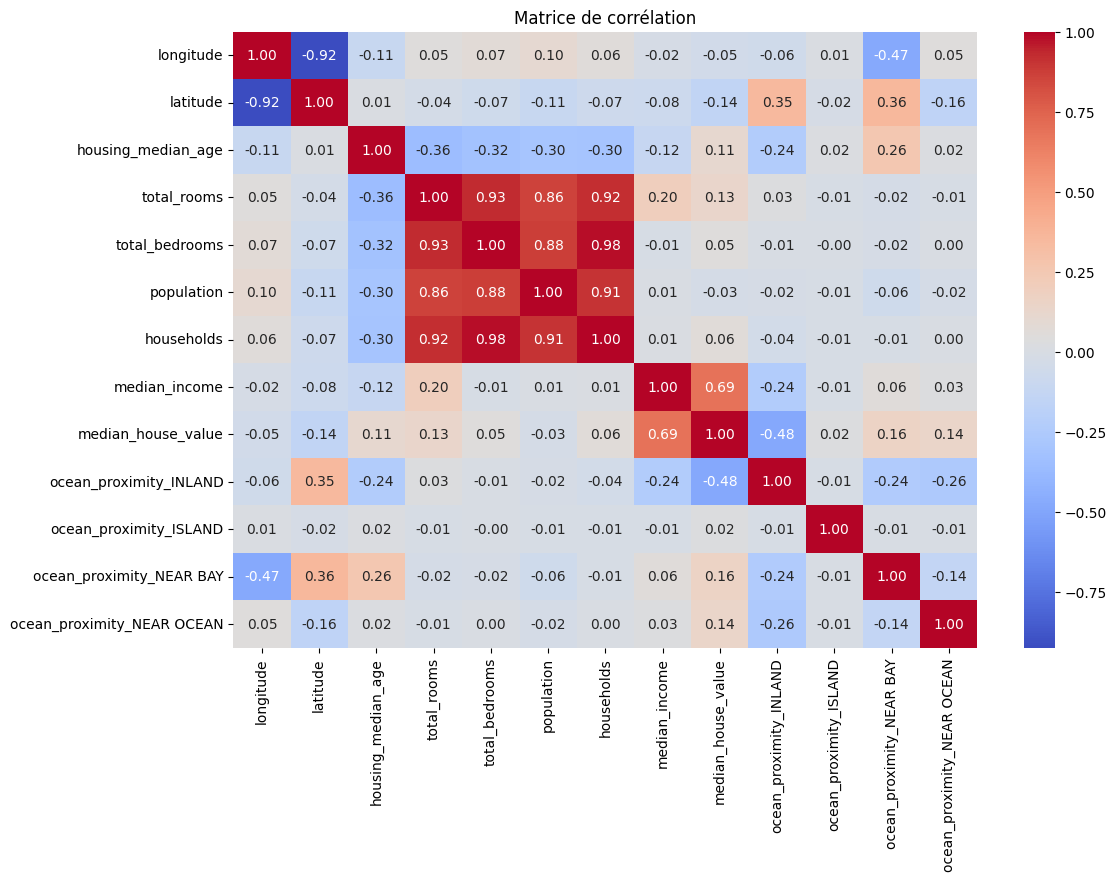

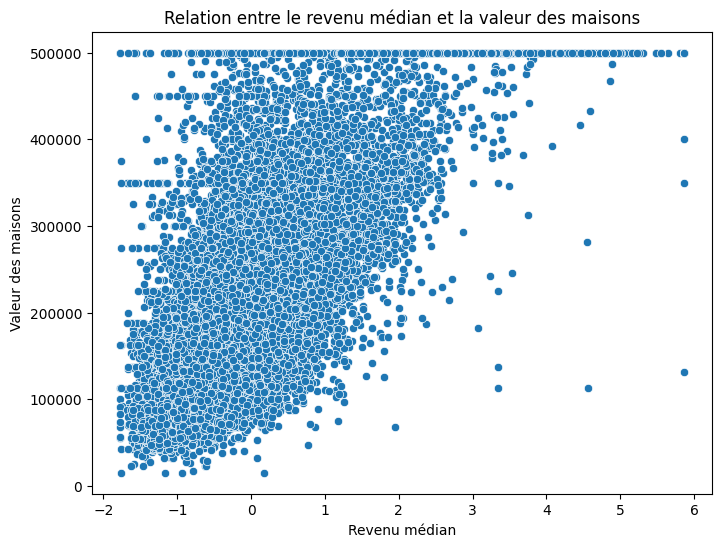

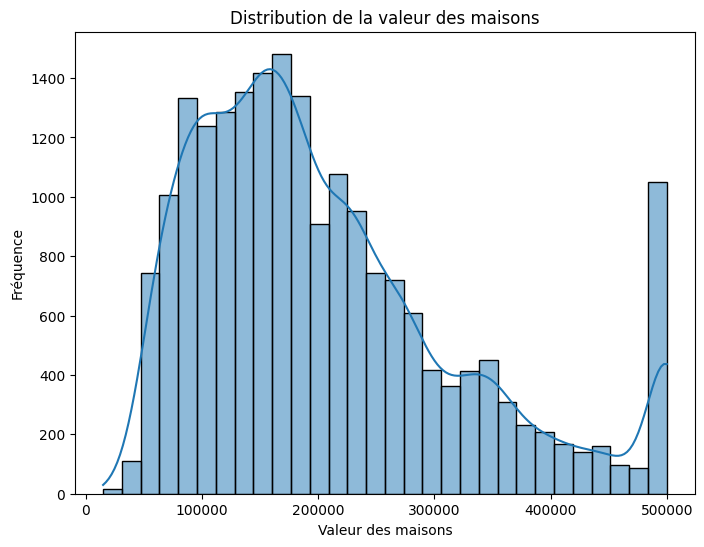

In [67]:
# Matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

# Relation entre 'median_income' et 'median_house_value'
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['median_income'], y=data['median_house_value'])
plt.title("Relation entre le revenu médian et la valeur des maisons")
plt.xlabel("Revenu médian")
plt.ylabel("Valeur des maisons")
plt.show()

# Distribution de 'median_house_value'
plt.figure(figsize=(8, 6))
sns.histplot(data['median_house_value'], kde=True, bins=30)
plt.title("Distribution de la valeur des maisons")
plt.xlabel("Valeur des maisons")
plt.ylabel("Fréquence")
plt.show()


In [68]:
# Création de nouvelles variables
data['rooms_per_household'] = data['total_rooms'] / data['households']
data['bedrooms_per_room'] = data['total_bedrooms'] / data['total_rooms']
data['population_per_household'] = data['population'] / data['households']

# Vérification des nouvelles colonnes
print(data[['rooms_per_household', 'bedrooms_per_room', 'population_per_household']].head())


   rooms_per_household  bedrooms_per_room  population_per_household
0             0.822876           1.207154                  0.996403
1             1.222560           0.660230                  0.515657
2             0.634542           1.542559                  0.971951
3             0.849976           1.152776                  1.042933
4             0.734534           1.324706                  1.206620


In [69]:
print(X.columns)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')


In [70]:
# Modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Évaluer le modèle
rf_score = rf_model.score(X_test, y_test)
print(f"Score du modèle Random Forest : {rf_score}")


Score du modèle Random Forest : 0.8260737800453686


In [71]:
# Paramètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Meilleurs paramètres : ", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

# Évaluer le modèle optimisé
best_rf_score = best_rf_model.score(X_test, y_test)
print(f"Score du modèle Random Forest optimisé : {best_rf_score}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Meilleurs paramètres :  {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Score du modèle Random Forest optimisé : 0.8269038401239455


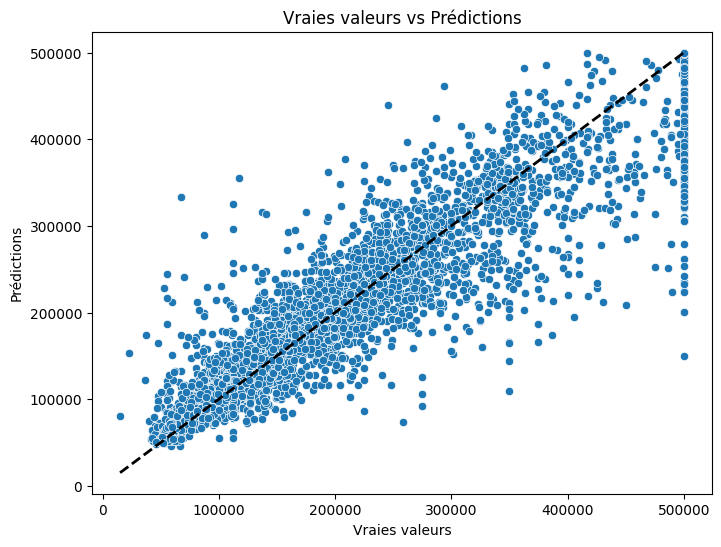

In [72]:
# Prédictions
y_pred = rf_model.predict(X_test)

# Visualisation des erreurs
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("Vraies valeurs vs Prédictions")
plt.xlabel("Vraies valeurs")
plt.ylabel("Prédictions")
plt.show()


In [73]:
# Validation croisée avec le modèle optimisé
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='r2')
print(f"Scores de validation croisée : {cv_scores}")
print(f"Score moyen : {cv_scores.mean()}")


Scores de validation croisée : [0.37035209 0.6081939  0.70404154 0.24099706 0.65132512]
Score moyen : 0.5149819426684966


In [74]:
# Transformation log
y_log = np.log1p(y)

# Refaire le splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Réentraîner le modèle
best_rf_model.fit(X_train, y_train)

# Score avec la transformation log
y_pred_log = best_rf_model.predict(X_test)
score_log = best_rf_model.score(X_test, y_test)
print(f"Score avec transformation log : {score_log}")


Score avec transformation log : 0.8425424401489456


In [75]:
# Suite TP3 (test)

# Définir l’expérience MLflow
mlflow.set_experiment("Housing Model Experiment")

with mlflow.start_run():

    # Loguer les hyperparamètres
    mlflow.log_param("model_type", "RandomForestRegressor")
    mlflow.log_param("n_estimators", best_rf_model.n_estimators)
    mlflow.log_param("max_depth", best_rf_model.max_depth)

    # Transformation log
    y_log = np.log1p(y)

    # Refaire le splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

    # Réentraîner le modèle
    best_rf_model.fit(X_train, y_train)

    # Score avec la transformation log
    y_pred_log = best_rf_model.predict(X_test)
    score_log = best_rf_model.score(X_test, y_test)

    # Loguer la métrique
    mlflow.log_metric("r2_score_log", score_log)

    # Enregistrer le modèle dans MLflow
    mlflow.sklearn.log_model(sk_model=best_rf_model, artifact_path="housing_rf_model")

    result = mlflow.register_model(
        model_uri=mlflow.get_artifact_uri("housing_rf_model"),
        name="Housing_Model_Lucas"
    )

print(f"Score avec transformation log : {score_log}")



2025/02/03 00:11:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Score avec transformation log : 0.8425424401489456


Registered model 'Housing_Model_Lucas' already exists. Creating a new version of this model...
Created version '5' of model 'Housing_Model_Lucas'.


In [76]:
# Sauvegarder le modèle optimisé
joblib.dump(best_rf_model, "random_forest_model.pkl")


['random_forest_model.pkl']

In [77]:
import mlflow.pyfunc

# Charger le modèle depuis MLflow Model Registry
model = mlflow.pyfunc.load_model("models:/Housing_Model_Lucas@champion")

# Faire une prédiction avec un échantillon de X_test
prediction = model.predict(X_test.iloc[0:1])

print("Prédiction MLflow :", prediction)


Prédiction MLflow : [12.22943869]


In [78]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Récupérer toutes les versions pour "Housing_Model_Lucas"
versions = client.search_model_versions("name='Housing_Model_Lucas'")
for v in versions:
    print(f"Version {v.version}")
    print(" - Aliases :", v.aliases)
    print(" - Source  :", v.source)
    print(" - Run ID  :", v.run_id)
    print()


Version 5
 - Aliases : []
 - Source  : file:///c:/Users/lucas/OneDrive/Documents/IA%20Institut/2024-2025/Cloud%20Engineering/TP1/housing-lucas-bonsergent/housing-model/mlruns/332725159403843891/04df8fa1f18245288729d5c5289fabdd/artifacts/housing_rf_model
 - Run ID  : None

Version 4
 - Aliases : ['champion']
 - Source  : file:///c:/Users/lucas/OneDrive/Documents/IA%20Institut/2024-2025/Cloud%20Engineering/TP1/housing-lucas-bonsergent/housing-model/mlruns/332725159403843891/e42558fe678d474197bd096658d8c58c/artifacts/housing_rf_model
 - Run ID  : None

Version 3
 - Aliases : []
 - Source  : file:///c:/Users/lucas/OneDrive/Documents/IA%20Institut/2024-2025/Cloud%20Engineering/TP1/housing-lucas-bonsergent/housing-model/mlruns/332725159403843891/eebd026a49764da88bf1dc247f62cc8c/artifacts/housing_rf_model
 - Run ID  : None

Version 2
 - Aliases : []
 - Source  : models:/Housing_Model_Lucas/1
 - Run ID  : a2778ff7e3c64400a6caf2d201317fae

Version 1
 - Aliases : []
 - Source  : file:///c:/Users